In [1]:
# Basic Libraries
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load dataset
data = pd.read_csv('train.csv')  # Update path as needed

# Define text and visual features
text_column = 'text'
visual_features = ['bright', 'cont', 'warm', 'colorf', 'sat', 'clar']  # Adjust based on your dataset
label_column = 'label'

# Extract features and labels
X_text = data[text_column]
X_visual = data[visual_features]
y = data[label_column]

# Split data into training and testing sets
X_text_train, X_text_test, X_visual_train, X_visual_test, y_train, y_test = train_test_split(
    X_text, X_visual, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
from sklearn.pipeline import Pipeline

# Text Processing Pipeline
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english'))  # Text to numerical features
])

# Visual Processing Pipeline
visual_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Standardize visual features
])


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Combine Text and Visual Pipelines
combined_pipeline = ColumnTransformer([
    ('text', text_pipeline, 'text'),      # Apply text pipeline to the text column
    ('visual', visual_pipeline, visual_features)  # Apply visual pipeline to visual features
])

# Full Multimodal Pipeline
model_pipeline = make_pipeline(
    combined_pipeline,
    RandomForestClassifier(n_estimators=100, random_state=42)  # Classifier
)

# Fit the model
X_train = pd.concat([X_text_train.reset_index(drop=True), X_visual_train.reset_index(drop=True)], axis=1)
X_train.columns = ['text'] + visual_features

model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('visual',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bright', 'cont', 'warm',
                                                   'colorf', 'sat',
                                                   'clar'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

Accuracy: 99.17%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1228
           1       0.99      0.99      0.99      1190

    accuracy                           0.99      2418
   macro avg       0.99      0.99      0.99      2418
weighted avg       0.99      0.99      0.99      2418



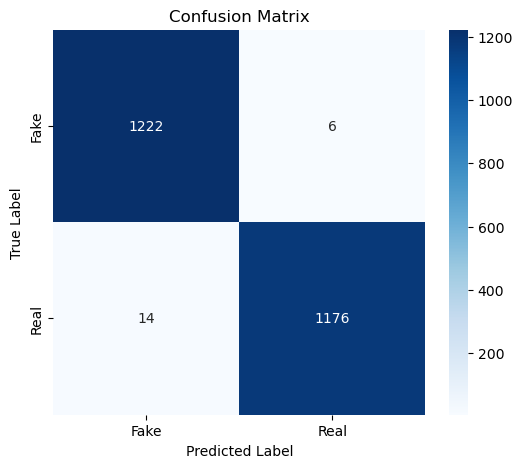

In [9]:
# Prepare test data
X_test = pd.concat([X_text_test.reset_index(drop=True), X_visual_test.reset_index(drop=True)], axis=1)
X_test.columns = ['text'] + visual_features

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


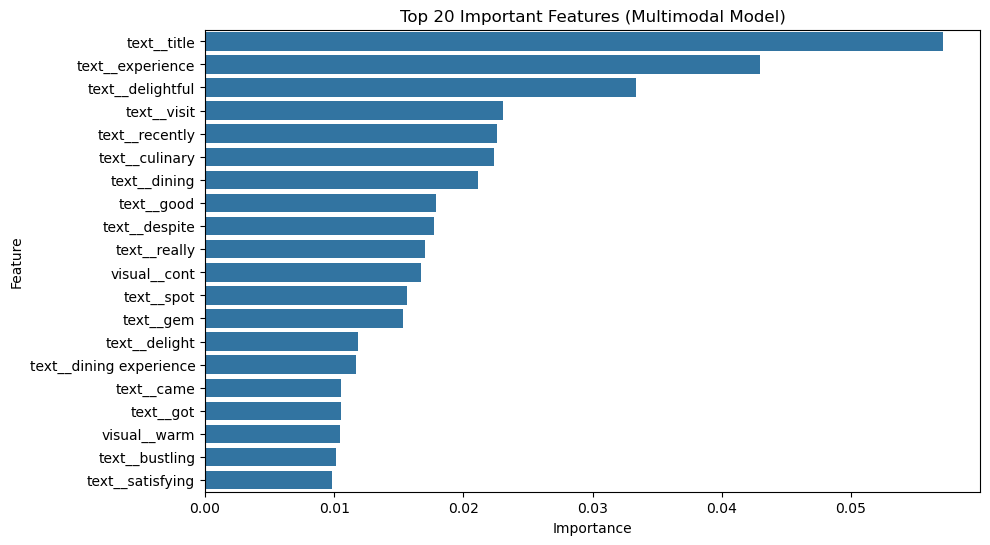

In [11]:
# Extract feature importances from Random Forest
rf_model = model_pipeline.named_steps['randomforestclassifier']
combined_features = model_pipeline.named_steps['columntransformer'].get_feature_names_out()

feature_importances = pd.DataFrame({
    'Feature': combined_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature')
plt.title("Top 20 Important Features (Multimodal Model)")
plt.show()
